In [1]:
import pandas as pd
import numpy as np
from functools import reduce
from sklearn.cluster import KMeans

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
import seaborn as sns

In [3]:
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

# Class 

Using the aggregation made from fake transactions we will generate a typical RFM (Recency, Frequency, Monetary) score
There are several way to create the score
    - Quantile based discretization (Using pandas qcut)
    - Kmeans clustering
    - Manual bin discretization based on the distribution of the features
    
In this example (as one I used in one of my RFM project) I use the 3 moethods together and I take the mean to smooth the effect of each one. This can be useful when you have very skew data or weird distributions. 
In real data also a subset of your data can be a good choice, but as always, the business needs, the reason of the project and the final goal.
In one of my previous project i removed people that didnt take an action for 6 months using a time period for RFM of 3 months.


The Class will have in input:
    - The aggregation file
    - format file
    
The scores are creating using:
    - R = days since last transaction at the end of each month
    - F = Number of transactions in the time period
    - M = Money spent in the time period (Revenue would be a better parameter)
    
The Class will do in order:
    - Read the data
    - Select the features necessary from the dataframe aggregate and change name with raw_parameter
    - Create score using pandas qcut function
    - Create score using manual bin function
    - Create score using kmeans clustering function
    - Merge all the score and generate the average scores
    - Generate the segments

In [4]:
class RFM:
    
    def __init__(self, file_name, type_format, agg='month', time_period = 3):
        self.file_name = file_name
        self.type_format = type_format
        self.agg = agg
        self.time_period = time_period
       
        self.read_data(file_name, type_format)
        self.get_raw_data()
        self.get_rfm_raw()
        
    def read_data(self, file_name, type_format):
        if type_format == 'csv':
            self.df_raw = pd.read_csv(file_name)
        elif type_format == 'parquet':
            self.df_raw = pd.read_parquet(file_name)
        else:
            print('dont Know')
    
    def get_raw_data(self):
        features = ['customer_id', 'month', 'days_since_last_at_end_of_the_month', 'cum_count', 'cum_sum_out', 'n_transaction_monthly', 'sum_out']
        self.df_rfm = self.df_raw[features]
        self.df_rfm = self.df_rfm.rename(columns = {'days_since_last_at_end_of_the_month': 'raw_r'})
        
# Get the RFM score 
    def get_rfm_raw(self):
        
        ids = ['customer_id', 'month']
        self.df_rfm = (
                self.df_rfm
                    .assign(
                        raw_f = lambda x : x.sort_values('month', ascending=True)
                            .groupby(['customer_id'])
                            .cum_count.diff(self.time_period).fillna(x.cum_count),
                        raw_m = lambda x : x.sort_values('month', ascending = True)
                            .groupby(['customer_id'])
                            .cum_sum_out.diff(self.time_period).fillna(x.cum_sum_out)))
        
        features = ids + [col for col in self.df_rfm.columns if col.startswith('raw_')]
        self.df_score = self.df_rfm[features]
        
    
    def get_rfm_score(self):

        def make_qcut(df):
            
            qcut_df = df.copy(deep=True)
            v_cols = [col for col in qcut_df.columns if col.startswith("raw_")]
            for col in v_cols:
                qcut_df['qcut_'+ '_'.join(col.split('_')[1:])] = pd.qcut(qcut_df[col], 5, labels=False, duplicates='drop')
            qcut_df = (
                qcut_df.drop(columns=v_cols) 
                .assign(
                qcut_r = lambda x: 5 - x.qcut_r,
                qcut_f = lambda x: x.qcut_f + 1,
                qcut_m = lambda x: x.qcut_m + 1
            ))
            return qcut_df
            
        def make_cut(df):
            
            m_bins = []   
            cut_df = df.copy(deep=True)
            v_cols = [col for col in cut_df.columns if col.startswith("raw_")]
            for ic in v_cols:
                f = pd.cut
                if ic == 'raw_r':
                    _bin =  [-0.1, 2, 10, 45, 90, np.inf]
                elif ic == 'raw_f':
                    _bin = [-0.1, 1, 20, 50, 100, np.inf]
                elif ic =='raw_m':
                    _bin = [-0.1, 25, 80, 250, 500,np.inf]
                    
                cut_df['cut_'+ic.split('_')[1]], v_bins = f(cut_df[ic], _bin, labels=False, retbins=True, duplicates='drop')

            cut_df = (
                cut_df.drop(columns=v_cols) 
                .assign(
                cut_r = lambda x: 5 - x.cut_r,
                cut_f = lambda x: x.cut_f + 1,
                cut_m = lambda x: x.cut_m + 1
            ))
            return cut_df
            
        def make_kmeans(df):
            
            def order_cluster_r(cluster_field_name, target_field_name,df,ascending):
                new_cluster_field_name = 'new_' + cluster_field_name
                df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
                df_new = df_new.sort_values(by=target_field_name,ascending=False).reset_index(drop=True)
                df_new['index'] = df_new.index
                df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
                df_final = df_final.drop([cluster_field_name],axis=1)
                df_final = df_final.rename(columns={"index":cluster_field_name})
                return df_final
        
            def order_cluster_fm(cluster_field_name, target_field_name,df,ascending):
                new_cluster_field_name = 'new_' + cluster_field_name
                df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
                df_new = df_new.sort_values(by=target_field_name,ascending=True).reset_index(drop=True)
                df_new['index'] = df_new.index
                df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
                df_final = df_final.drop([cluster_field_name],axis=1)
                df_final = df_final.rename(columns={"index":cluster_field_name})
                return df_final
            
            kmeans_df = df.copy(deep=True)
            for col in kmeans_df.columns:
                if col.startswith('raw'):
                    if col.split('_')[1]=='r':
                        kmeans_r = KMeans(n_clusters=5)
                        kmeans_r.fit(kmeans_df[[col]])
                        
                        kmeans_name_columns = 'kmeans_'+ '_'.join(col.split('_')[1:])
                        kmeans_df[kmeans_name_columns] = kmeans_r.predict(kmeans_df[[col]])
                        
                        kmeans_df = order_cluster_r(kmeans_name_columns, col, kmeans_df, False)
                    
                    elif col.split('_')[1]=='f':
                        kmeans_f = KMeans(n_clusters=5)
                        kmeans_f.fit(kmeans_df[[col]])
                        
                        kmeans_name_columns = 'kmeans_'+ '_'.join(col.split('_')[1:])
                        kmeans_df[kmeans_name_columns] = kmeans_f.predict(kmeans_df[[col]])
                        
                        kmeans_df = order_cluster_fm(kmeans_name_columns, col, kmeans_df, False)

                    elif col.split('_')[1]=='m':
                        kmeans_m = KMeans(n_clusters=5)        
                        kmeans_m.fit(kmeans_df[[col]])
                        
                        kmeans_name_columns = 'kmeans_'+ '_'.join(col.split('_')[1:])
                        kmeans_df[kmeans_name_columns] = kmeans_m.predict(kmeans_df[[col]])
                        
                        kmeans_df = order_cluster_fm(kmeans_name_columns, col, kmeans_df, False)
            
            kmeans_df = kmeans_df.drop([col for col in kmeans_df.columns if col.startswith('raw_')], axis=1)
            
            adding_col = [col for col in kmeans_df.columns if col.startswith('kmeans_')]
            kmeans_df[adding_col] += 1
            
            return kmeans_df

            
        
        self.qcut_df = make_qcut(self.df_score)
        self.cut_df = make_cut(self.df_score)
        self.kmeans_df = make_kmeans(self.df_score)
        
    def merge_df(self):
        
        dfs = [self.df_score, self.cut_df, self.qcut_df,  self.kmeans_df] #self.cut_df,
        self.final_score = reduce(lambda left, right : pd.merge(left, right, how='left', on=['month', 'customer_id']), dfs)
        
        for col in self.final_score.columns:
            if self.final_score[col].dtypes == 'int64' or self.final_score[col].dtypes == 'float64':
                self.final_score[col] = self.final_score[col] 
            else:
                self.final_score[col] = self.final_score[col]
        

    def make_segment(self):
        
        segt_map = {
            r'[1-2][1-2]': 'hibernating', #1
            r'[1-2][3-4]': 'at_risk', #3
            r'[1-2]5': 'cant_loose', #2
            r'3[1-2]': 'about_to_sleep', #4
            r'33': 'need_attention', #5
            r'[3-4][4-5]': 'loyal_customers', #9
            r'41': 'promising', #6
            r'51': 'new_customers', #7
            r'[4-5][2-3]': 'potential_loyalists', #8
            r'5[4-5]': 'champions' #10
        }
        
        
        segt_map_n = {
            r'[1-2][1-2]': 1,
            r'[1-2]5': 2,
            r'[1-2][3-4]': 3,
            r'3[1-2]': 4,
            r'33': 5,
            r'41': 6,
            r'51': 7,
            r'[4-5][2-3]': 8,
            r'[3-4][4-5]': 9,
            r'5[4-5]': 10
        }
        
        fix = ['month', 'customer_id']
        
        self.segment = (
                self.final_score
                .assign(
                    avg_r = lambda x : (x.qcut_r + x.kmeans_r + x.cut_r)/3,
                    avg_f = lambda x : (x.qcut_f + x.kmeans_f + x.cut_f)/3,
                    avg_m = lambda x : (x.qcut_m + x.kmeans_m + x.cut_m)/3,
                    round_r = lambda x : round(x.avg_r).astype(int),
                    round_f = lambda x : round(x.avg_f).astype(int),
                    round_m = lambda x : round(x.avg_m).astype(int),
                    f_score = lambda x : x.round_r.astype(str) + x.round_f.astype(str) + x.round_m.astype(str),
                    avg_segment = lambda x : (x.avg_r.map(round).astype(str) + x.avg_f.map(round).astype(str)).replace(segt_map, regex=True),
                    avg_n_segment = lambda x : (x.avg_r.map(round).astype(str) + x.avg_f.map(round).astype(str)).replace(segt_map_n, regex=True))
                )
        feat_avg = fix + [col for col in self.segment.columns if col.startswith('avg')]
        #self.segment = self.segment[feat_avg]
        
    def show_all_df(self):
        all_df = [self.df_raw, self.segment]
        self.total_df = reduce(lambda left, right : pd.merge(left, right, how='left', on=['month','customer_id']), all_df)
    
       


# Use case

In [5]:
R = RFM('aggregate_month.csv', 'csv')

In [6]:
R.get_rfm_score()

In [7]:
R.merge_df()

In [8]:
R.final_score.head()

,customer_id,month,raw_r,raw_f,raw_m,cut_r,cut_f,cut_m,qcut_r,qcut_f,qcut_m,kmeans_r,kmeans_f,kmeans_m
0,1,2018-01-01,2,1.0,0.00,5,1,1,4,1,1,5,1,1
1,503,2018-01-01,0,7.0,116.15,5,2,3,5,2,2,5,1,1
2,51,2018-01-01,0,7.0,122.41,5,2,3,5,2,2,5,1,1
3,502,2018-01-01,0,11.0,231.54,5,2,3,5,2,2,5,1,1
4,501,2018-01-01,0,1.0,0.00,5,1,1,5,1,1,5,1,1


In [9]:
R.make_segment()

In [10]:
R.segment.head()

,customer_id,month,raw_r,raw_f,raw_m,cut_r,cut_f,cut_m,qcut_r,qcut_f,qcut_m,kmeans_r,kmeans_f,kmeans_m,avg_r,avg_f,avg_m,round_r,round_f,round_m,f_score,avg_segment,avg_n_segment
0,1,2018-01-01,2,1.0,0.00,5,1,1,4,1,1,5,1,1,4.666667,1.000000,1.0,5,1,1,511,new_customers,7
1,503,2018-01-01,0,7.0,116.15,5,2,3,5,2,2,5,1,1,5.000000,1.666667,2.0,5,2,2,522,potential_loyalists,8
2,51,2018-01-01,0,7.0,122.41,5,2,3,5,2,2,5,1,1,5.000000,1.666667,2.0,5,2,2,522,potential_loyalists,8
3,502,2018-01-01,0,11.0,231.54,5,2,3,5,2,2,5,1,1,5.000000,1.666667,2.0,5,2,2,522,potential_loyalists,8
4,501,2018-01-01,0,1.0,0.00,5,1,1,5,1,1,5,1,1,5.000000,1.000000,1.0,5,1,1,511,new_customers,7


In [11]:
R.df_score.head()

,customer_id,month,raw_r,raw_f,raw_m
0,1,2018-01-01,2,1.0,0.00
1,503,2018-01-01,0,7.0,116.15
2,51,2018-01-01,0,7.0,122.41
3,502,2018-01-01,0,11.0,231.54
4,501,2018-01-01,0,1.0,0.00


In [12]:
R.show_all_df()

In [13]:
R.total_df.head()

,customer_id,month,n_months,days_to_next_max,days_since_last_at_end_of_the_month,days_since_first,sum_in,sum_out,cum_sum_in,cum_sum_out,count_in,count_out,cum_count_in,cum_count_out,cum_count,n_transaction_monthly,balance,count_incoming_bigger_than_100,count_incoming_bigger_than_500,count_incoming_bigger_than_1000,cum_n_incoming_bigger_than_100,cum_n_incoming_bigger_than_500,cum_n_incoming_bigger_than_1000,cum_monday,monday,cum_tuesday,tuesday,cum_wednesday,wednesday,cum_thursday,thursday,cum_friday,friday,cum_saturday,saturday,cum_sunday,sunday,sum_in_relative,sum_out_relative,count_in_relative,count_out_relative,count_tnx_type,month_of_first_transaction,month_of_last_transaction,churn,active_months,days_in_month,raw_r,raw_f,raw_m,cut_r,cut_f,cut_m,qcut_r,qcut_f,qcut_m,kmeans_r,kmeans_f,kmeans_m,avg_r,avg_f,avg_m,round_r,round_f,round_m,f_score,avg_segment,avg_n_segment
0,1,2018-01-01,1,6.0,2,2,16.06,0.00,16.06,0.00,1.0,0.0,1.0,0.0,1.0,1.0,16.06,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,0.00,1.00,0.00,1.0,1.0,0.0,0,1,31,2,1.0,0.00,5,1,1,4,1,1,5,1,1,4.666667,1.000000,1.0,5,1,1,511,new_customers,7
1,503,2018-01-01,1,1.0,0,2,15.49,116.15,15.49,116.15,1.0,6.0,1.0,6.0,7.0,7.0,-100.66,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,3.0,3.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.12,0.88,0.14,0.86,3.0,1.0,0.0,0,1,31,0,7.0,116.15,5,2,3,5,2,2,5,1,1,5.000000,1.666667,2.0,5,2,2,522,potential_loyalists,8
2,51,2018-01-01,1,2.0,0,2,0.00,122.41,0.00,122.41,0.0,7.0,0.0,7.0,7.0,7.0,-122.41,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.00,1.00,0.00,1.00,3.0,1.0,0.0,0,1,31,0,7.0,122.41,5,2,3,5,2,2,5,1,1,5.000000,1.666667,2.0,5,2,2,522,potential_loyalists,8
3,502,2018-01-01,1,1.0,0,2,0.00,231.54,0.00,231.54,0.0,11.0,0.0,11.0,11.0,11.0,-231.54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,8.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1.00,0.00,1.00,2.0,1.0,0.0,0,1,31,0,11.0,231.54,5,2,3,5,2,2,5,1,1,5.000000,1.666667,2.0,5,2,2,522,potential_loyalists,8
4,501,2018-01-01,1,1.0,0,2,23.20,0.00,23.20,0.00,1.0,0.0,1.0,0.0,1.0,1.0,23.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,0.00,1.00,0.00,1.0,1.0,0.0,0,1,31,0,1.0,0.00,5,1,1,5,1,1,5,1,1,5.000000,1.000000,1.0,5,1,1,511,new_customers,7


### Saving

In [13]:
R.segment.to_csv('segment.csv', index = False)
R.total_df.to_csv('total_df.csv', index = False)

# Extra: RFM and plots

The best options would be open your csv files in Tableau (or a similar tool) and have amazing visualization and quick analysis.
If that is not possible here a quick way to visualize the segments, for analysis and storytelling

### Visualize the segments in time

In [14]:
R.segment['month'] = pd.to_datetime(R.segment['month']) 

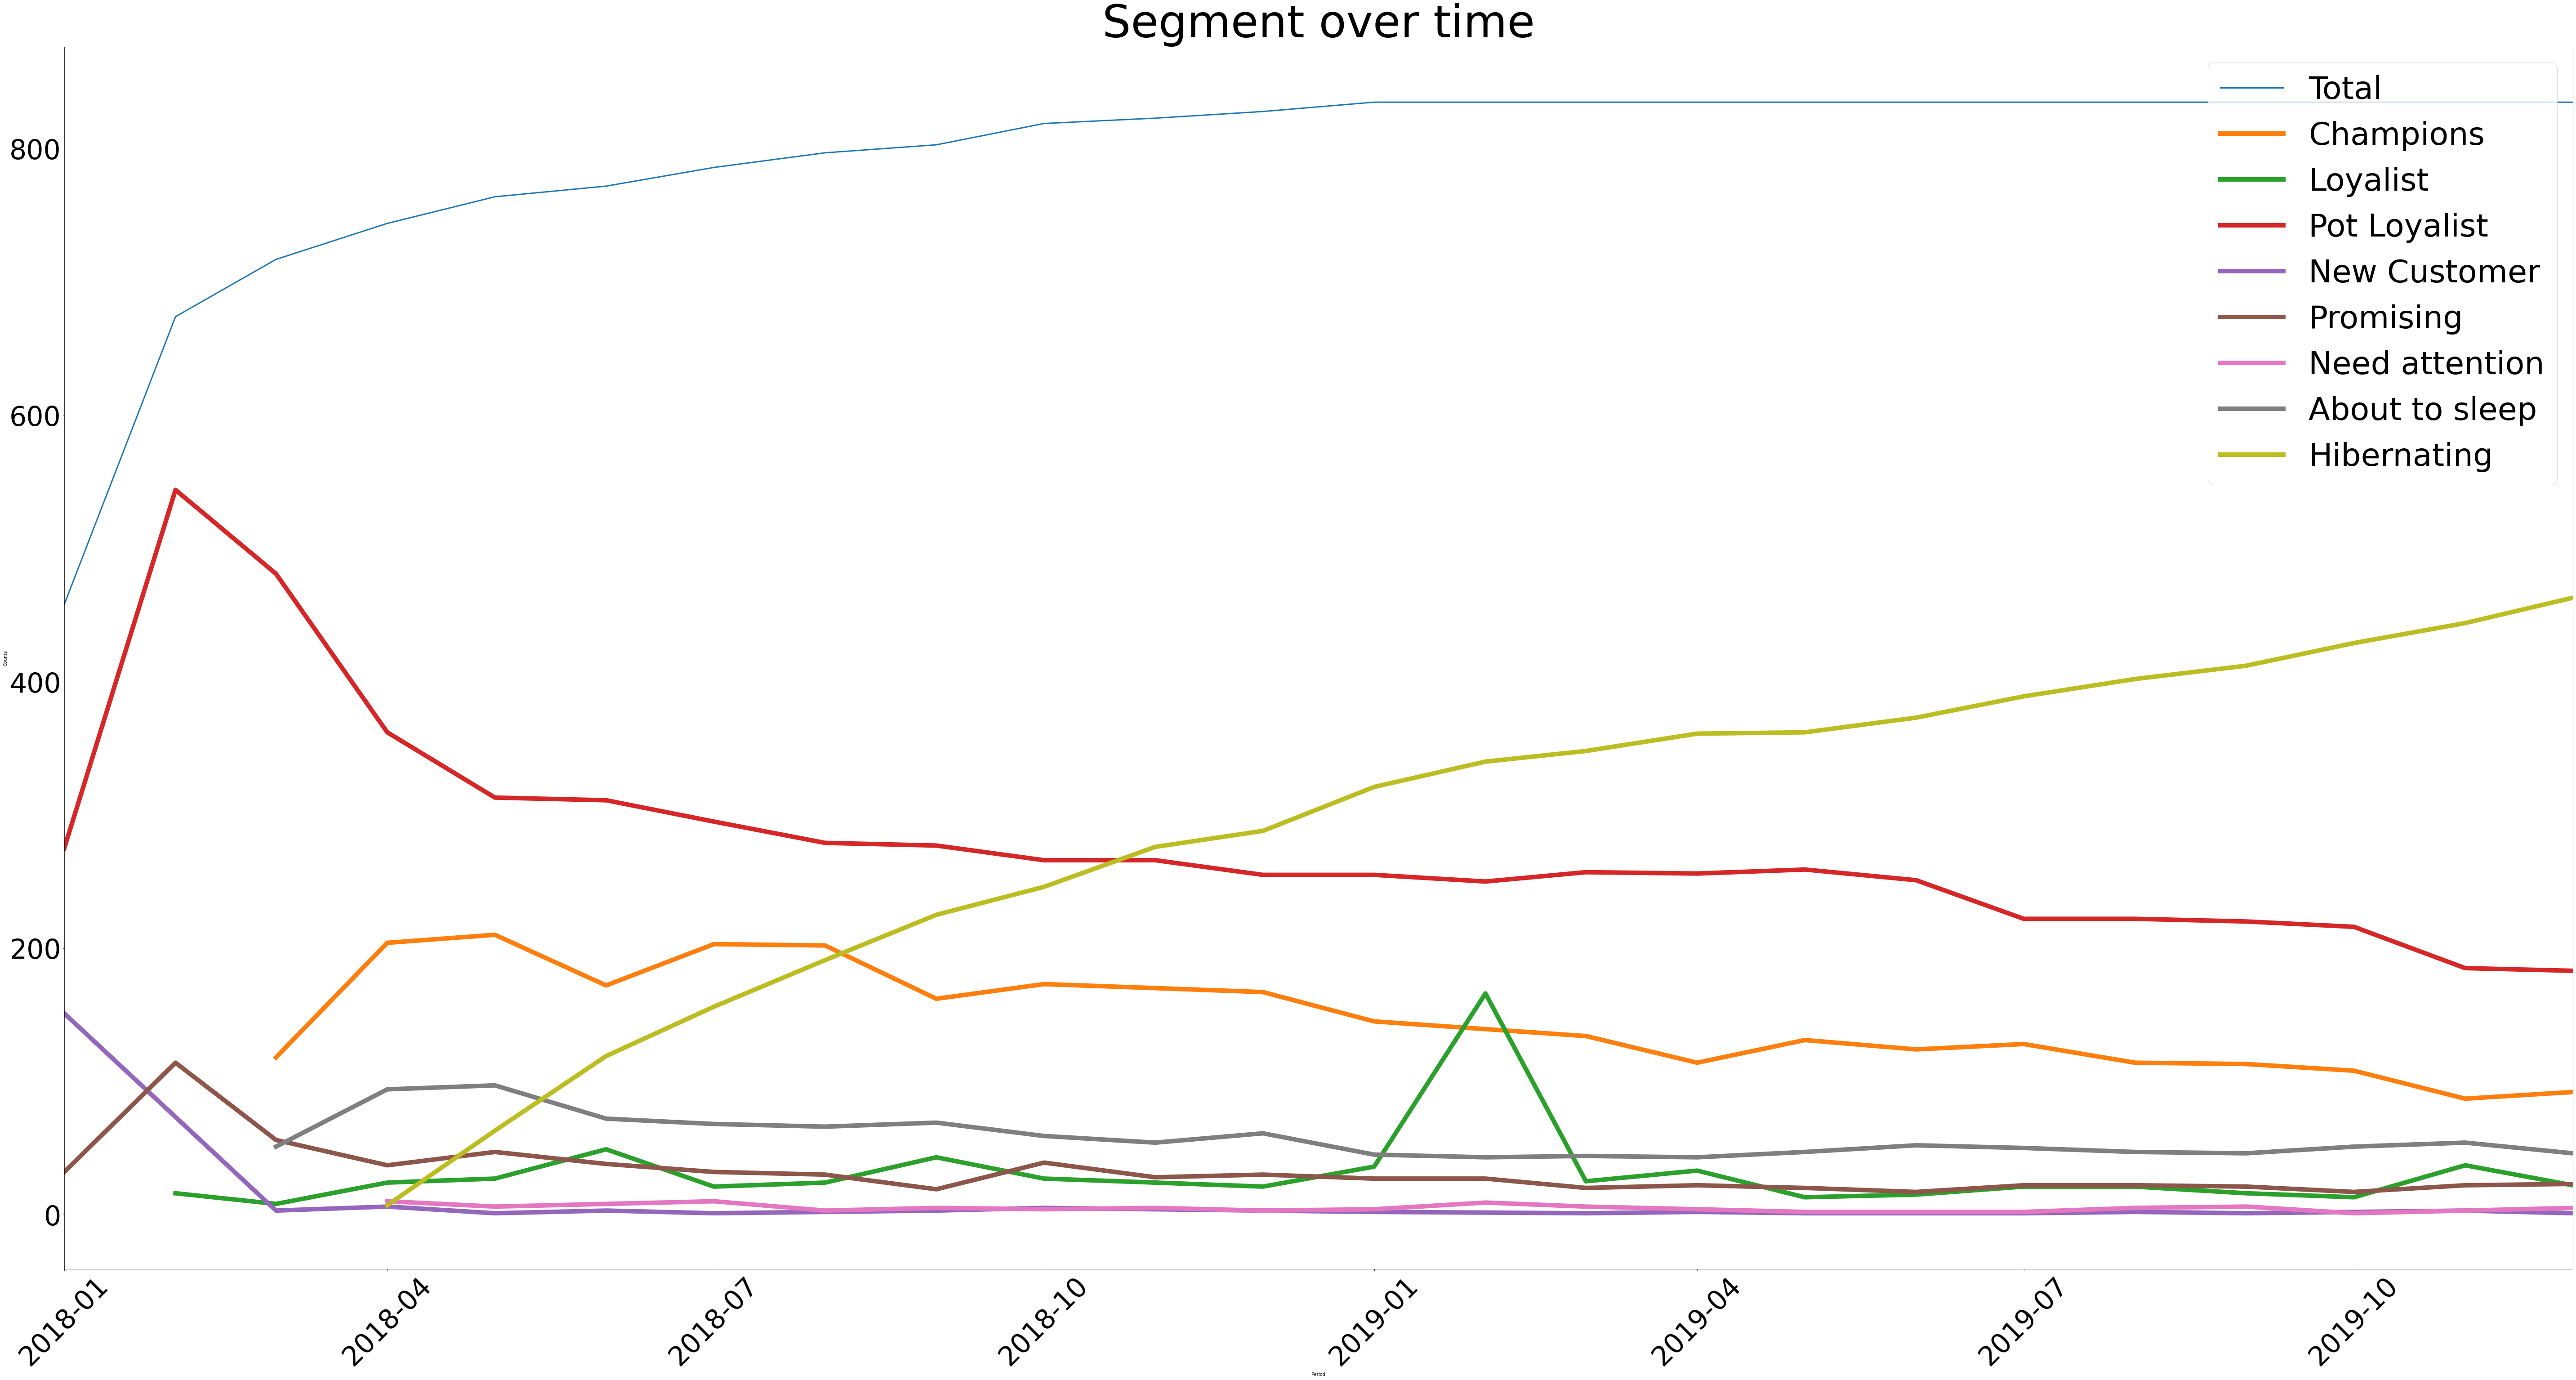

In [15]:
#In this autogenerate sample of data we are missing 2 segments
plt.figure(figsize=(100,50))
R.segment.groupby(R.segment['month'].dt.date).size().plot(linewidth=3.0)
R.segment[R.segment.avg_n_segment == 10].groupby(R.segment['month'].dt.date).size().plot(linewidth=10.0)
R.segment[R.segment.avg_n_segment == 9].groupby(R.segment['month'].dt.date).size().plot(linewidth=10.0)
R.segment[R.segment.avg_n_segment == 8].groupby(R.segment['month'].dt.date).size().plot(linewidth=10.0)
R.segment[R.segment.avg_n_segment == 7].groupby(R.segment['month'].dt.date).size().plot(linewidth=10.0)
R.segment[R.segment.avg_n_segment == 6].groupby(R.segment['month'].dt.date).size().plot(linewidth=10.0)
R.segment[R.segment.avg_n_segment == 5].groupby(R.segment['month'].dt.date).size().plot(linewidth=10.0)
R.segment[R.segment.avg_n_segment == 4].groupby(R.segment['month'].dt.date).size().plot(linewidth=10.0)
#R.segment[R.segment.avg_n_segment == 3].groupby(R.segment['month'].dt.date).size().plot(linewidth=10.0) 
#R.segment[R.segment.avg_n_segment == 2].groupby(R.segment['month'].dt.date).size().plot(linewidth=10.0)
R.segment[R.segment.avg_n_segment == 1].groupby(R.segment['month'].dt.date).size().plot(linewidth=10.0)



plt.title('Segment over time', fontsize=100)
plt.xticks(fontsize=60, rotation=45)
plt.yticks(fontsize=60)
plt.xlabel('Period')
plt.ylabel('Counts')
L = plt.legend(prop={'size': 70})
L.get_texts()[0].set_text('Total')
L.get_texts()[1].set_text('Champions')
L.get_texts()[2].set_text('Loyalist')
L.get_texts()[3].set_text('Pot Loyalist')
L.get_texts()[4].set_text('New Customer')
L.get_texts()[5].set_text('Promising')
L.get_texts()[6].set_text('Need attention')
L.get_texts()[7].set_text('About to sleep')
#L.get_texts()[8].set_text('At risk')
#L.get_texts()[9].set_text('Cant loose')
L.get_texts()[8].set_text('Hibernating')


plt.show()

### Heatmap of segment vs different features

In [16]:
def plot_heatmap(df, v_columns, how='median', how_div='r'):
    v_columns += ['avg_n_segment', 'avg_segment']
    df_fm = df[v_columns]

    if how == 'mean':
        df_g = df_fm.groupby(['avg_n_segment', 'avg_segment'], as_index=False).agg(np.mean).sort_values(['avg_n_segment'])
    else:
        df_g = df_fm.groupby(['avg_n_segment', 'avg_segment'], as_index=False).agg(np.median).sort_values(['avg_n_segment'])

    m_data = df_g.values[:,2:]
    m_data = np.asarray(m_data, np.float)
    
    def get_np_div_max(m_m, how='r'):
        if how == 'c':
            return np.divide(m_m, m_m.max(axis=1, keepdims=True))
        if how == 'r':
            return np.divide(m_m, m_m.max(axis=0, keepdims=True))
        else:
            return np.divide(m_m, m_m.max())
        
    m_data = get_np_div_max(m_data, how=how_div)
    v_cols = df_g.avg_segment
    v_rows = df_g.columns[2:]
    
    def plotmat(m_m, v_columns=None, v_rows=None, c_title='MatrixPlot', file_name=None, figsize=(8,3)):
        if v_columns is None:
            v_columns = np.array(['col_{}'.format(ii) for ii in range(m_m.shape[1])])
        if v_rows is None:
            v_rows = np.array(['row_{}'.format(ii) for ii in range(m_m.shape[0])])

        cmap = ListedColormap(sns.color_palette("Blues").as_hex())

        fig, ax = plt.subplots(figsize=figsize)

        im = ax.matshow(m_m, aspect='auto', origin='lower', cmap=cmap)
        fig.colorbar(im)
        
        
        ax.set_xticks(range(v_columns.shape[0]))
        ax.set_xticklabels(v_columns, minor=False)
        ax.tick_params(axis='x', rotation=90, bottom=True)
        ax.xaxis.tick_bottom()

        ax.set_yticks(range(v_rows.shape[0]))
        ax.set_yticklabels(v_rows, minor=False)
        ax.yaxis.tick_left()
        ax.tick_params(axis='both', labelsize=20)
        ax.set_title(c_title, fontsize=50)

        plt.tight_layout()
    
    plotmat(m_data, v_columns=v_rows, v_rows=v_cols, c_title='Features {} values'.format(how), file_name='plotmat_{}'.format(how), figsize=(30,15))
        

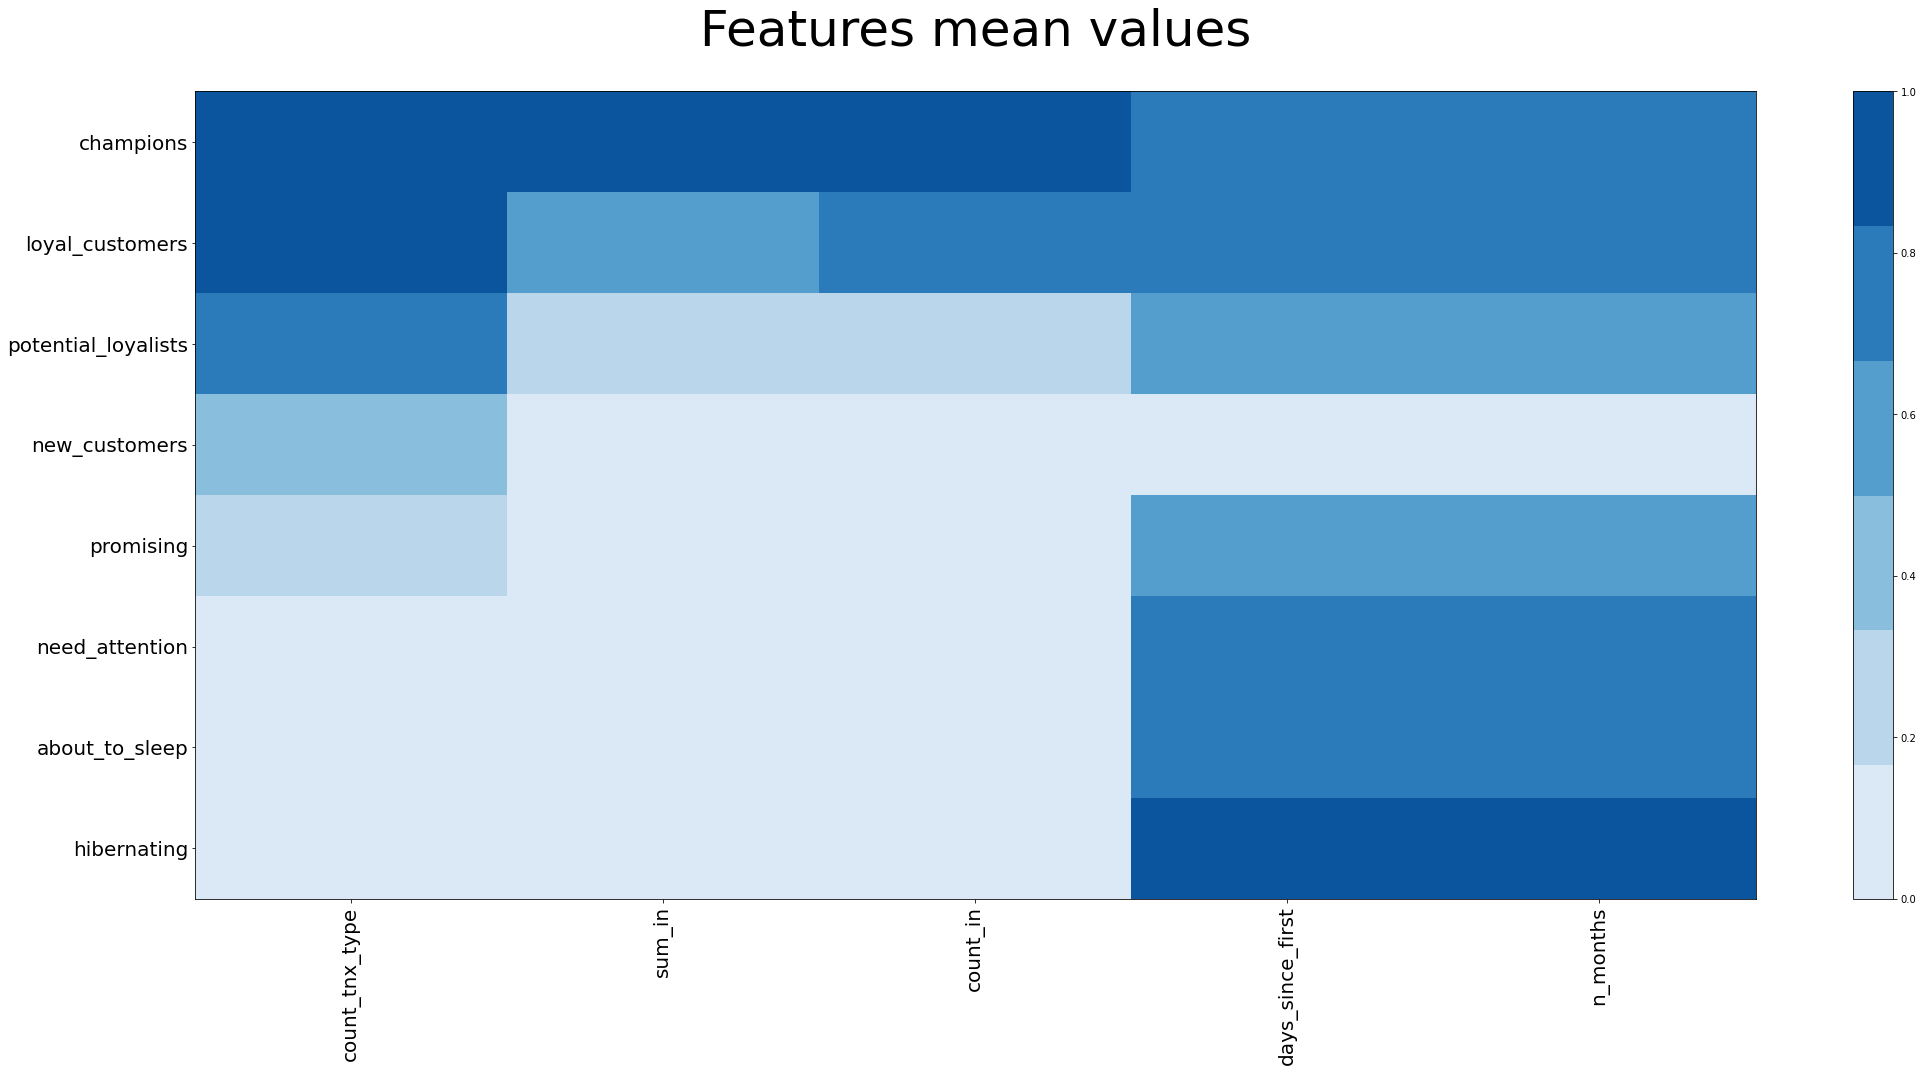

In [17]:
columns = ['count_tnx_type',
           'sum_in',
           'count_in',
           'days_since_first',
           'n_months']
plot_heatmap(R.total_df, columns,'mean')

### Create the Bubble plot with the 2d segment in the graph

In [18]:
from pylab import *
from matplotlib.patches import Rectangle
from collections import Counter


In [19]:
def plot_segment(x, y, s, col):
    plt.figure(figsize=(20,20))
    axes = plt.gca()
    plt.scatter(x, y, s, col, cmap=cm.coolwarm, alpha=0.5)
    axes.add_patch(Rectangle((0,0),2.5,2.5,linewidth=1,color='grey',alpha= 0.5, zorder=-100)) #hibernating
    axes.add_patch(Rectangle((2.5,0),1,2.5,linewidth=1,color='darkgoldenrod',alpha= 0.5, zorder=-100))  #about to sleep
    axes.add_patch(Rectangle((0,2.5),2.5,2,linewidth=1,color='orange',alpha= 0.5, zorder=-100)) #at risk
    axes.add_patch(Rectangle((0,4.5),2.5,1,linewidth=1,color='red', alpha= 0.5, zorder=-100)) #can't loose them
    axes.add_patch(Rectangle((2.5,2.5),1,1,linewidth=1,color='yellow', alpha= 0.5, zorder=-100)) # need attention
    axes.add_patch(Rectangle((3.5,0),1,1.5,linewidth=1,color='darkslategray', alpha= 0.5, zorder=-100)) # promising
    axes.add_patch(Rectangle((4.5,0),1,1.5,linewidth=1,color='azure', alpha= 0.5, zorder=-100)) # new customer
    axes.add_patch(Rectangle((3.5,1.5),2,2,linewidth=1,color='purple', alpha= 0.5, zorder=-100)) # potential loyalist
    axes.add_patch(Rectangle((2.5,3.5),2,2,linewidth=1,color='blue', alpha= 0.5, zorder=-100)) # loyal customer
    axes.add_patch(Rectangle((4.5,3.5),1,2,linewidth=1,color='green', alpha= 0.5, zorder=-100)) # champions
    axes.set_xlim([0,5.5])
    axes.set_ylim([0,5.5])
    
    plt.title('RFM ', fontsize=40)
    plt.ylabel('Frequency', fontsize=25)
    plt.xlabel('Recency', fontsize=25)
    cbar= plt.colorbar()
    
    
    
    plt.show()

In [20]:
def create_subset_discrete(df, month):
    subset = df[df.month==month]
    y = subset.avg_f
    x = subset.avg_r
    colors = subset.avg_m
    c = Counter(zip(x,y))
    #since we are dealing with a small sample 10 is necessary to create a decent size bubble, need to be reduced for a bigger dataframe
    area = [10*c[(xx,yy)] for xx,yy in zip(x,y)] 
    return subset, x, y, colors, area

- The size of the bubbles is the size of sample in that position
- The color of the bubbles is the M value
- On the 2 axis you have the R and F
- On the background the segment are part 
- The average give more an idea of continous but if you use only one method the goal is the same, just with less density

2019-10-01T00:00:00.000000000
plotting
2019-10-01T00:00:00.000000000


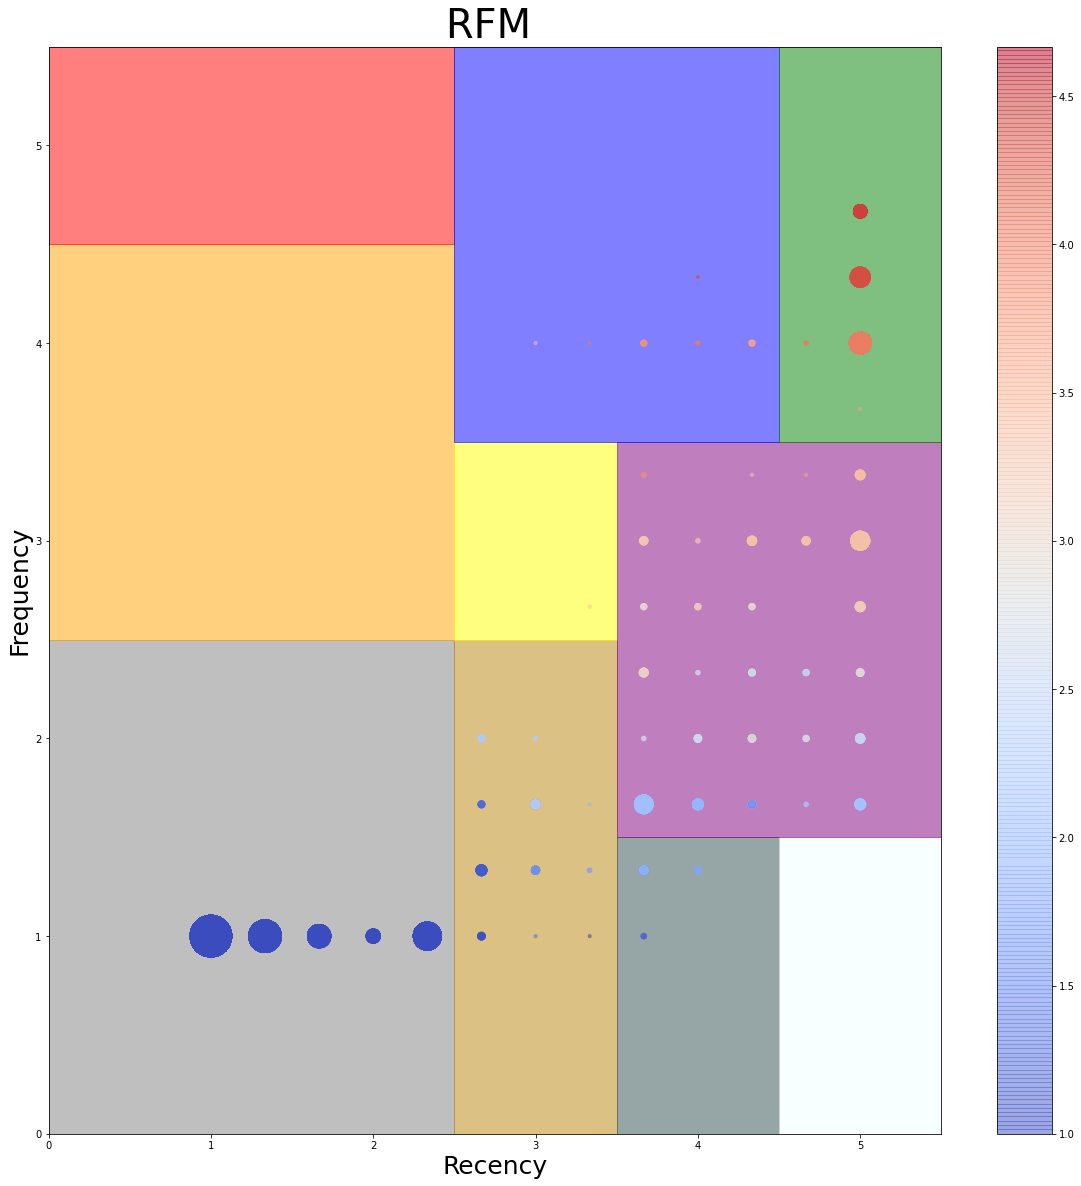



2019-11-01T00:00:00.000000000
plotting
2019-11-01T00:00:00.000000000


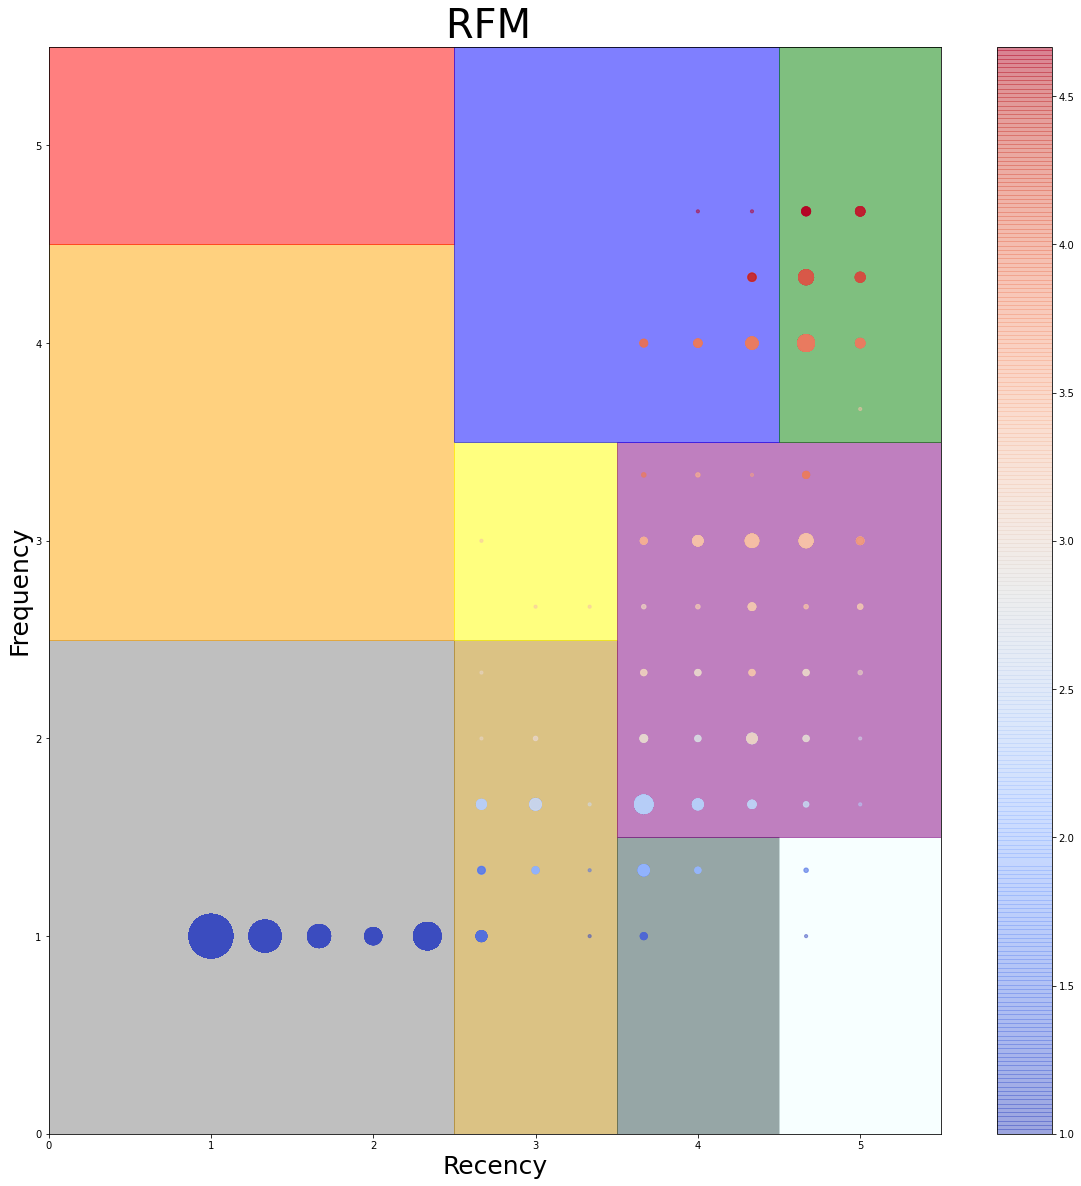



2019-12-01T00:00:00.000000000
plotting
2019-12-01T00:00:00.000000000


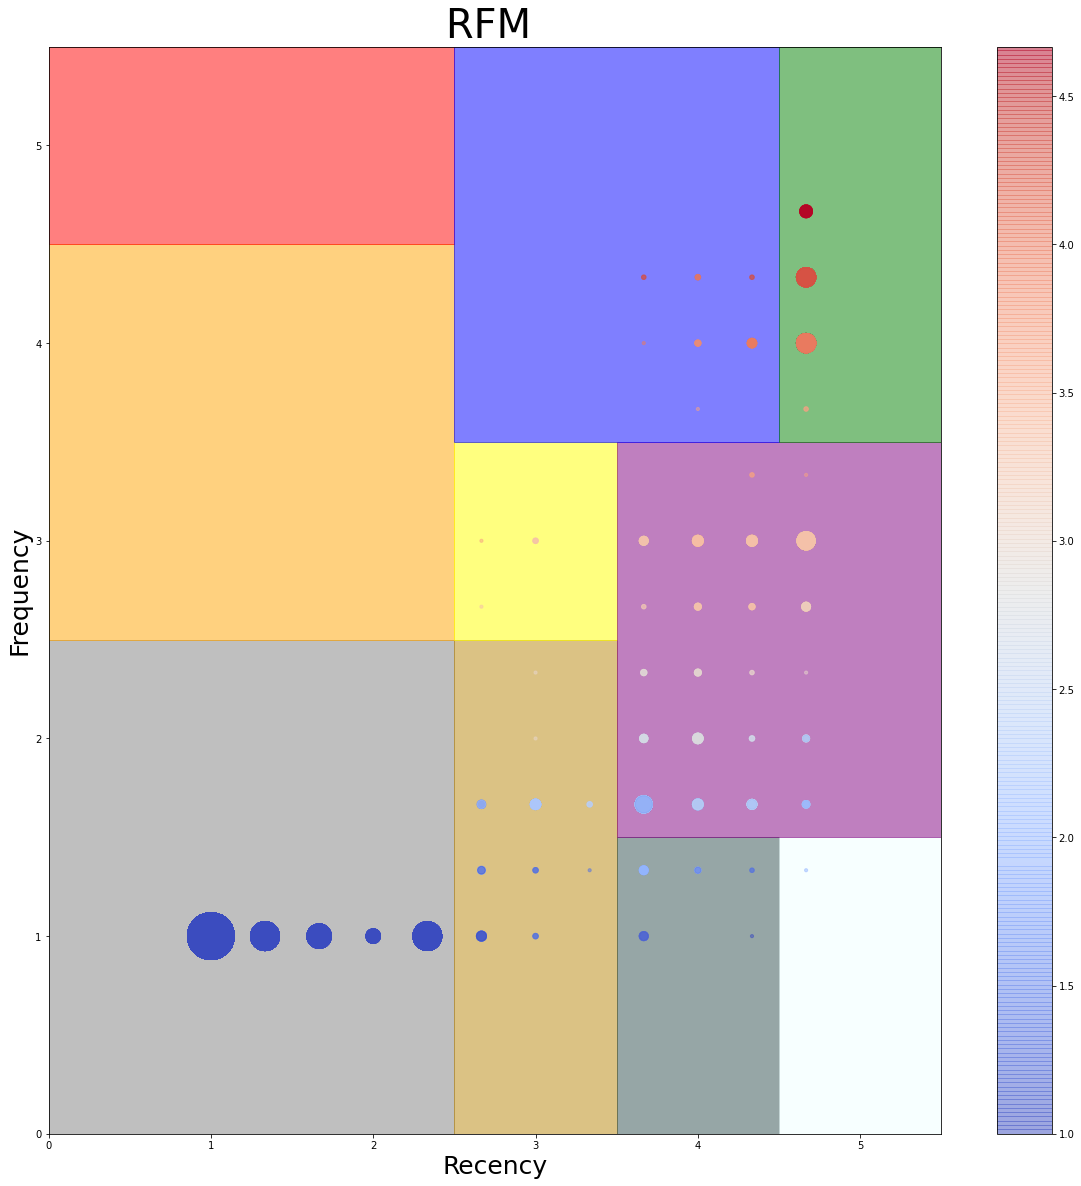

In [22]:
for month in R.segment.month.unique()[-3:]:
    print(month)
    subset, x, y, colors, area = create_subset_discrete(R.segment, month)
    ts = pd.to_datetime(str(month)) 
    
   
    print('plotting')
    print(month)
    
    plot_segment(x, y, area, colors)
    print()
    print()